# Genetic Algorithm for Finding the Optimal Neural Network Weights

## Imports

In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Data preparation

In [2]:
# Load the iris dataset.
iris = load_iris()
X: np.ndarray = iris.data
y: np.ndarray = iris.target

In [3]:
# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
# Scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
X_train: torch.Tensor = torch.from_numpy(X_train).float()
X_test: torch.Tensor = torch.from_numpy(X_test).float()
y_train: torch.Tensor = torch.from_numpy(y_train).long()
y_test: torch.Tensor = torch.from_numpy(y_test).long()

In [6]:
# Create the 'models' directory.
models_path = Path("models")
models_path.mkdir(exist_ok=True)

## Model definition

In [31]:
# Create the model.
def create_model() -> nn.Module:
    model = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 3)
    )
    return model

In [32]:
iris_model = create_model()

In [8]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()

In [9]:
# Evaluate the model.
def calculate_metrics(x: torch.Tensor, yt: torch.Tensor) -> None:
    # Calculate the crossentropy loss of the trained model.
    with torch.no_grad():
        preds = iris_model(x)
        loss = criterion(preds, yt).item()
    print(f"Crossentropy : {loss}")
    # Calculate the classification accuracy for the trained model.
    acc = torch.mean((torch.argmax(preds, dim=1) == yt).float()).item()
    print(f"Accuracy : {acc}")

## Implementation using our own Genetic Algorithm

In [10]:
from genalg import GeneticAlgorithm, ModelParams

In [11]:
# Move the model and data to the GPU.
iris_model = iris_model.cuda()
X_train = X_train.cuda()
y_train = y_train.cuda()
X_test = X_test.cuda()
y_test = y_test.cuda()

In [12]:
def load_params(model: nn.Module, params: ModelParams) -> None:
    model_params = model.state_dict()
    model_params['0.weight'] = torch.FloatTensor(params[:40].reshape(10, 4))
    model_params['0.bias'] = torch.FloatTensor(params[40:50])
    model_params['2.weight'] = torch.FloatTensor(params[50:80].reshape(3, 10))
    model_params['2.bias'] = torch.FloatTensor(params[80:])
    model.load_state_dict(model_params)

In [13]:
def on_generation(generation: int, scores: list[float]) -> None:
    print(
        f"Generation: {generation:0=3} "
        f"Best fitness: {np.max(scores):.10f} "
        f"Average fitness: {np.mean(scores):.10f} "
        f"Worst fitness: {np.min(scores):.10f}"
    )

In [14]:
def fitness_fn(solution: ModelParams) -> float:
    load_params(iris_model, solution)
    with torch.no_grad():
        outputs = iris_model(X_train)
        loss: torch.Tensor = criterion(outputs, y_train)
        fitness = 1.0 / (loss.detach().item() + 1e-8)
    return fitness

In [15]:
# Create the GA instance
ga = GeneticAlgorithm(
    model=iris_model,
    population_size=30,
    num_generations=600,
    neuron_off_rate=1e-4,
    mutation_rate=0.05,
    elitism=True,
    fitness_fn=fitness_fn,
    on_generation=on_generation,
    on_generation_interval=50,
)

In [16]:
# Run the algorithm
ga.run()

Generation: 000 Best fitness: 1.5433719701 Average fitness: 0.7456111161 Worst fitness: 0.3869804614
Generation: 050 Best fitness: 3.2446750755 Average fitness: 2.8953651866 Worst fitness: 2.5158817894
Generation: 100 Best fitness: 4.6345184663 Average fitness: 4.1108275911 Worst fitness: 3.6450487630
Generation: 150 Best fitness: 6.5672342767 Average fitness: 5.9685807182 Worst fitness: 5.3553919008
Generation: 200 Best fitness: 8.3287108567 Average fitness: 7.0848136781 Worst fitness: 3.4031687845
Generation: 250 Best fitness: 12.6944537912 Average fitness: 11.0748490952 Worst fitness: 9.8534413135
Generation: 300 Best fitness: 15.1424719381 Average fitness: 12.3759145992 Worst fitness: 9.4984964174
Generation: 350 Best fitness: 17.7112536249 Average fitness: 15.5143250450 Worst fitness: 10.0451293478
Generation: 400 Best fitness: 20.0449864118 Average fitness: 18.0141691243 Worst fitness: 13.2955562995
Generation: 450 Best fitness: 20.8989814569 Average fitness: 18.3574158359 Worst 

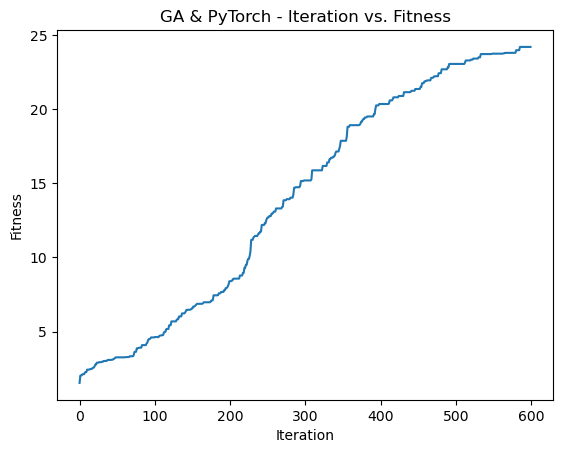

In [17]:
# Plot the fitness curve.
ga.plot_fitness()

In [18]:
# Print GA summary.
ga.print_summary()

Best solution fitness: 24.1857370245993
Best solution: [ 0.18715172  0.15843318 -1.05434587 -1.30217583  0.26030023 -0.71766392
  2.69708382  1.3531205   0.08579807  0.18079343  0.25286524 -0.05260483
  0.31478894 -0.87733846  0.48281432 -0.50686909 -0.39182396 -0.57261652
  1.17258718  0.01352583 -0.98486466  1.39464695 -0.66739439  0.94024504
  0.71045271  1.16046207  0.80569554 -1.10788079 -0.78427624  0.23453702
 -1.57879494 -0.92889878  0.5513221   0.11980191  0.10801034 -0.50687703
  0.14014693  0.29700998 -0.85096398 -0.75774799  1.9433681  -0.0402826
 -0.75891708  1.06899817 -0.02800371  0.17027197 -0.70863922 -0.43104126
  1.27716565  1.81859791  2.37010683 -1.79990589 -1.03808332 -1.29238132
 -1.77009436  0.5101736   0.01736589  1.33964889  0.13270038 -0.01749015
  0.54685065 -1.06010791  0.30295317  1.00407869 -0.58897297 -0.34617195
 -0.61965038 -1.82661163  1.40953616  1.72751561 -0.89229886  2.01358346
  0.39942932 -1.43569824  0.40446863 -1.64048457  0.18089689  0.502062

In [19]:
# Load the weights of the best solution into the model.
best_solution = ga.best_solution
load_params(iris_model, best_solution)

In [44]:
# Define the path to save the model weights.
weights_path = models_path / "ga_weights.pth"

In [45]:
# Load model weights into the model.
iris_model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [46]:
# Calculate the metrics of the best solution.
print("On the training set:")
calculate_metrics(X_train, y_train)
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the training set:
Crossentropy : 0.04134668409824371
Accuracy : 0.9851852059364319
On the testing set:
Crossentropy : 0.011164525523781776
Accuracy : 1.0


In [22]:
# Save the model weights.
torch.save(iris_model.state_dict(), weights_path)

## Implementation using PyGAD library

In [23]:
import pygad
import pygad.torchga as torchga

In [24]:
# Move the model and data to the CPU.
iris_model = iris_model.cpu()
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

In [27]:
# Define the parameters.
sol_per_pop = 10
num_generations = 200

In [33]:
# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(
    model=iris_model,
    num_solutions=sol_per_pop,
)

In [34]:
# Some parameters are initialized within the constructor.
initial_population = torch_ga.population_weights

In [35]:
# Define the fitness function for classification.
def fitness_func(_ga: pygad.GA, sol: np.ndarray, _sol_idx: int) -> float:
    preds = torchga.predict(model=iris_model,
                            solution=sol,
                            data=X_train)
    fitness = 1.0 / (criterion(preds, y_train).detach().numpy() + 1e-8)
    return fitness

In [36]:
# Define the callback function.
# noinspection PyShadowingNames
def on_generation(ga: pygad.GA) -> None:
    print(f'Gen#{ga.generations_completed:0=2}, Fitness: {ga.best_solution()[1]}')

In [37]:
# Create an instance of the GA class inside the ga module.
ga = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=sol_per_pop // 2,
    initial_population=initial_population,
    fitness_func=fitness_func,
    on_generation=on_generation,
)

In [38]:
# Run the genetic algorithm.
ga.run()

Gen#01, Fitness: 1.1462431390911512
Gen#02, Fitness: 1.3782244462485254
Gen#03, Fitness: 1.6434267082233411
Gen#04, Fitness: 2.0910567869953676
Gen#05, Fitness: 2.3221536955337085
Gen#06, Fitness: 2.4399529919353755
Gen#07, Fitness: 2.819310360374253
Gen#08, Fitness: 3.3773839235950436
Gen#09, Fitness: 3.3773839235950436
Gen#10, Fitness: 3.93229732217669
Gen#11, Fitness: 4.541282484569421
Gen#12, Fitness: 4.541282484569421
Gen#13, Fitness: 5.766837921426559
Gen#14, Fitness: 5.766837921426559
Gen#15, Fitness: 5.766837921426559
Gen#16, Fitness: 5.766837921426559
Gen#17, Fitness: 5.766837921426559
Gen#18, Fitness: 5.766837921426559
Gen#19, Fitness: 5.766837921426559
Gen#20, Fitness: 5.766837921426559
Gen#21, Fitness: 5.766837921426559
Gen#22, Fitness: 5.766837921426559
Gen#23, Fitness: 5.766837921426559
Gen#24, Fitness: 5.766837921426559
Gen#25, Fitness: 5.766837921426559
Gen#26, Fitness: 5.78911728522874
Gen#27, Fitness: 6.032727220315084
Gen#28, Fitness: 6.032727220315084
Gen#29, Fitnes

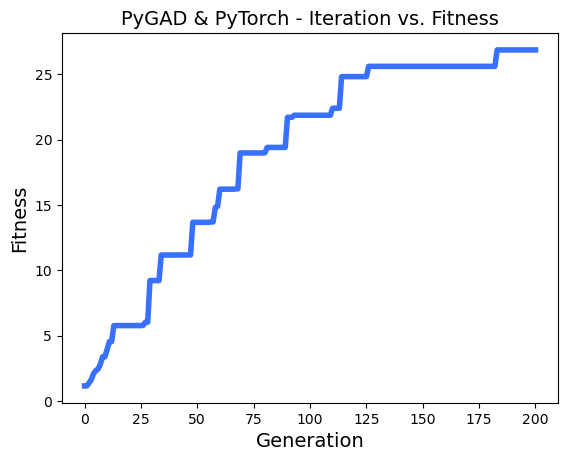

In [39]:
# After the generations complete, some plots are shown that summarize
# how the outputs/fitness values evolve over generations.
_ = ga.plot_fitness(
    title="PyGAD & PyTorch - Iteration vs. Fitness",
    linewidth=4
)

In [40]:
# Returning the details of the best solution.
best_solution, best_solution_fitness, best_solution_idx = ga.best_solution()
print(f"Fitness value of the best solution = {best_solution_fitness}")
print(f"Index of the best solution : {best_solution_idx}")

Fitness value of the best solution = 26.87747657480332
Index of the best solution : 0


In [41]:
# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(
    model=iris_model,
    weights_vector=best_solution
)
iris_model.load_state_dict(best_solution_weights)

<All keys matched successfully>

In [42]:
print("On the training set:")
calculate_metrics(X_train, y_train)
print("On the testing set:")
calculate_metrics(X_test, y_test)

On the training set:
Crossentropy : 0.03720586374402046
Accuracy : 0.9851852059364319
On the testing set:
Crossentropy : 0.012011809274554253
Accuracy : 1.0


In [43]:
# Save the model weights.
weights_path = models_path / "pygad_weights.pth"
torch.save(iris_model.state_dict(), weights_path)